In [30]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.Markovian_fBiPotDDims.recursive_Markovian_PostMeanScore_fBiPot12Dims_T256_H05_tl_110data_StbleTgt import get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
num_paths = 10240
root_dir ="/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"
config = get_config()

In [32]:
def get_drift_files(config, root_dir):
    ts_type = f"{config.ndims}DDims"
    include = (f"_{num_paths}NPaths_{config.t0}t0_{config.deltaT:.3e}dT_").replace(".", "")
    root_nadaraya_dir = root_dir + f"ExperimentResults/Nadaraya/12DDims/"
    true_files = []
    local_files = []
    for file in os.listdir(root_nadaraya_dir):
        print(file)
        if "IIDNadaraya" in file and ts_type in file and include in file:
            if "true" in file:
                true_files.append(root_nadaraya_dir+file)
            elif "local" in file:
                local_files.append(root_nadaraya_dir+file)
    assert len(true_files)>0, "No true files found"
    assert len(local_files)>0, "No local files found"
    assert (len(true_files) == len(local_files))
    def extract_bw_number(s):
        match = s.split("/")[-1].split("_")[4][:-2]
        return float("0." + match)
    true_files = sorted(true_files, key=extract_bw_number)
    local_files = sorted(local_files, key=extract_bw_number)
    bws = [extract_bw_number(f) for f in true_files]
    return true_files, local_files, bws

In [33]:
true_files, local_files, bws = get_drift_files(config=config, root_dir=root_dir)
local_files

IIDNadaraya_fBiPot_12DDims_DriftTrack_0008604bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_local_states.npy
IIDNadaraya_fBiPot_12DDims_DriftTrack_0000305bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_true_states.npy
IIDNadaraya_fBiPot_12DDims_DriftTrack_0010359bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_local_states.npy
IIDNadaraya_fBiPot_12DDims_DriftEvalExp_0003401bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_isdriftHats.npy
IIDNadaraya_fBiPot_12DDims_DriftEvalExp_0012471bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_isdriftHats.npy
IIDNadaraya_fBiPot_12DDims_DriftEvalExp_0031549bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_isdriftHats.npy
IIDNadaraya_fBiPot_12DDims_DriftTrack_0007146bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_true_states.npy
IIDNadaraya_fBiPot_12DDims_DriftTrack_0000253bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_global_states.npy
IIDNadaraya_fBiPot_12DDims_DriftTrack_0000367bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_global_states.npy
IIDNadaraya_fBiPot_12DDims_DriftTr

['/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/Nadaraya/12DDims/IIDNadaraya_fBiPot_12DDims_DriftTrack_00001bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_local_states.npy',
 '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/Nadaraya/12DDims/IIDNadaraya_fBiPot_12DDims_DriftTrack_000012bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_local_states.npy',
 '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/Nadaraya/12DDims/IIDNadaraya_fBiPot_12DDims_DriftTrack_0000145bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_local_states.npy',
 '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/Nadaraya/12DDims/IIDNadaraya_fBiPot_12DDims_DriftTrack_0000175bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_local_states.npy',
 '/Users/marcos/Library

In [ ]:
curr_rmse = np.inf
toSave = False
i = 0
for file in zip(*[true_files, local_files, bws]):
    bw = file[-1]
    all_true_states = np.load(file[0])/np.sqrt(config.deltaT)
    all_local_states = np.load(file[1])/np.sqrt(config.deltaT)
    if (len(all_true_states.shape) == len(all_local_states.shape) == 4):
        all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean((all_local_errors), axis=0)
        total_local_errors_minq = np.quantile((all_local_errors), axis=0,q=0.025)
        total_local_errors_maxq = np.quantile((all_local_errors), axis=0,q=0.975)
        print(total_local_errors[-1], total_local_errors_maxq[-1]-total_local_errors_minq[-1], curr_rmse, i)
        i += 1
        if total_local_errors[-1]  < curr_rmse:
            miny = total_local_errors-total_local_errors_minq
            miny[miny < 0.] = 0.
            maxy = total_local_errors_maxq-total_local_errors
            maxy[maxy < 0.] = 0.
            time_steps = np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0])
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            ax.scatter(np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0]), total_local_errors)
            plt.errorbar(time_steps,total_local_errors,yerr=[miny, maxy],xerr=None, fmt='o', color="blue", alpha=0.4)
            ax.set_title(f"Cumulative MSE for Nadaraya Estimator",fontsize=40)
            ax.set_ylabel("MSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((root_dir + f"DiffusionModelPresentationImages/IIDNadaraya_fBiPot_{config.ndims}DDims_DriftTrack_{round(bw, 6)}bw_{round(total_local_errors_minq[-1], 8)}_MinIQR_{round(total_local_errors[-1], 8)}MeanIQR_{round(total_local_errors_maxq[-1], 8)}_MaxIQR").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with IQR ({total_local_errors_minq[-1], total_local_errors_maxq[-1]})at bw {bw}\n")
        print(f"Bandwidth, BWIDX, Error Mean, Error IQR, CurrMSE {bw, np.argwhere(np.array(bws)==bw)[0,0], total_local_errors[-1], total_local_errors_maxq[-1]-total_local_errors_minq[-1], curr_rmse}\n")

In [34]:
def get_evalexpdrift_files(config, root_dir):
    ts_type = f"{config.ndims}DDims"
    include = (f"_{num_paths}NPaths_{config.t0}t0_{config.deltaT:.3e}dT_").replace(".", "")
    root_nadaraya_dir = root_dir + f"ExperimentResults/Nadaraya/12DDims/"
    driftevalexp_files = []
    for file in os.listdir(root_nadaraya_dir):
        if "EvalExp" in file and ts_type in file and include in file:
            driftevalexp_files.append(root_nadaraya_dir+file)
    assert len(driftevalexp_files)>0, "No evalexp files found"
    def extract_bw_number(s):
        match = s.split("/")[-1].split("_")[4][:-2]
        return float("0." + match)
    driftevalexp_files = sorted(driftevalexp_files, key=extract_bw_number)
    bws = [extract_bw_number(f) for f in driftevalexp_files]
    return driftevalexp_files, bws

In [35]:
eval_exp_files, bws = get_evalexpdrift_files(config=config, root_dir=root_dir)
bws

[1e-05,
 1.2e-05,
 1.45e-05,
 1.75e-05,
 2.1e-05,
 2.53e-05,
 3.05e-05,
 3.67e-05,
 4.41e-05,
 5.32e-05,
 6.4e-05,
 7.7e-05,
 9.28e-05,
 0.0001117,
 0.0001345,
 0.0001619,
 0.0001949,
 0.0002346,
 0.0002825,
 0.0003401,
 0.0004095,
 0.000493,
 0.0005936,
 0.0007146,
 0.0008604,
 0.0010359,
 0.0012471,
 0.0015015,
 0.0018078,
 0.0021765,
 0.0026204,
 0.0031549,
 0.0037983,
 0.004573,
 0.0055057,
 0.0066287,
 0.0079807,
 0.0096084,
 0.0115682]

In [8]:
def plot_drift_estimator(mean, mean_min, mean_max, numpy_Xs, true_drift, bw,  toSave: bool = False):
    mse = np.nanmean((true_drift- mean)**2).astype(
        np.float64)
    fig, axes = plt.subplots(6, 2, figsize=(30, 34))
    axes = axes.flatten()  # Flatten to easily index with a single loop
    for d in range(mean.shape[-1]):
        axes[d].scatter(numpy_Xs[:, d], true_drift[:, d], color="red", label="True Drift")
        ymin = mean[:, d] - mean_min[:, d]
        ymax = mean_max[:, d] - mean[:, d]
        ymin[ymin < 0.] = 0.
        ymax[ymax < 0.] = 0.
        axes[d].errorbar(numpy_Xs[:, d], mean[:, d], yerr=[ymin, ymax], xerr=None, fmt='o', color="blue", alpha=0.4)
        axes[d].errorbar(numpy_Xs[:, d], mean[:, d], label="Estimated Drift", color="blue")
        axes[d].set_title(rf"MSE {round(mse, 6)} for Nadaraya Estimator", fontsize=22)
        axes[d].tick_params(labelsize=13)
        axes[d].set_xlabel(f"State $X$ at Dimension {d+1}", fontsize=20)
        axes[d].set_ylabel("Drift Value", fontsize=20)
        axes[d].legend(fontsize=14)
    plt.tight_layout()
    if toSave:
        plt.savefig((root_dir + f"DiffusionModelPresentationImages/IIDNadaraya_fBiPot_{config.ndims}DDims_DriftEvalExp_{round(bw, 6)}bw").replace(".", "")+".png")
        plt.show()
        plt.close()
        print(f"Final time domain MSE local-time error {total_local_errors[-1]} at bw {bw}\n")
    plt.show()
    plt.close()

In [8]:
curr_best_mse = np.inf
toSave = False
Xshape = 256
bw_idx = 0
Xs = np.concatenate([np.linspace(-5, 5, num=Xshape).reshape(-1,1), np.linspace(-4.7, 4.7, num=Xshape).reshape(-1,1), \
                                     np.linspace(-4.4, 4.4, num=Xshape).reshape(-1,1), np.linspace(-4.2, 4.2, num=Xshape).reshape(-1,1), \
                                     np.linspace(-4.05, 4.05, num=Xshape).reshape(-1,1), np.linspace(-3.9, 3.9, num=Xshape).reshape(-1,1), \
                                     np.linspace(-3.7, 3.7, num=Xshape).reshape(-1,1), np.linspace(-3.6, 3.6, num=Xshape).reshape(-1,1), \
                                     np.linspace(-3.55, 3.55, num=Xshape).reshape(-1,1),
                                     np.linspace(-3.48, 3.48, num=Xshape).reshape(-1,1), \
                                     np.linspace(-3.4, 3.4, num=Xshape).reshape(-1,1), np.linspace(-3.4, 3.4, num=Xshape).reshape(-1,1)],
                                    axis=1)
is_true_drift = -(4. * np.array(config.quartic_coeff) * np.power(Xs,3) + 2. * np.array(
        config.quad_coeff) * Xs + np.array(config.const))
for file in zip(*[eval_exp_files, bws]):
    bw = file[-1]
    print(bw)
    try:
        f = np.load(file[0])
        is_drift = f.mean(axis=1)
        print(is_drift.shape)
        mse = np.nanmean((is_true_drift-is_drift)**2)
        if mse < np.inf:#curr_best_mse:
            mu_hats_minq = np.quantile(f, q=0.025, axis=1) # Lower bound
            mu_hats_maxq = np.quantile(f, q=0.975, axis=1) # uPPER bound
            print(is_drift.shape, is_true_drift.shape, Xs.shape)
            plot_drift_estimator(mean=is_drift, mean_min=mu_hats_minq, mean_max=mu_hats_maxq, numpy_Xs=Xs, true_drift=is_true_drift, bw=bw)
            curr_best_mse = mse
            print(f"MSE  {mse} with IQR ({mu_hats_minq, mu_hats_maxq})at BW {bw} at BWIDX {bw_idx}\n")
        bw_idx += 1
    except FileNotFoundError as e:
        continue

RuntimeError: 

In [25]:
np.load(local_files[5]).reshape((1000, 257, 12))[:, :3, :]

array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.10458249,  0.15139404,  0.00719696, ...,  0.02687327,
         -0.48020021,  0.39466125],
        [ 0.11825212,  0.43032198,  0.24590827, ..., -0.21027818,
         -0.84416784,  0.24755569]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.2514893 ,  0.11280376, -0.14835842, ..., -0.49182291,
          0.22184461, -0.33205946],
        [ 0.55837127, -0.03779373, -0.82502427, ..., -0.30363328,
          0.1507435 , -0.3742213 ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.03289495, -0.09049232,  0.19550778, ..., -0.12888265,
         -0.05490935,  0.10058648],
        [ 0.05001486,  0.19421124,  0.29012484, ..., -0.06843165,
          0.26668026,  0.03013194]],

       ...,

       [[ 0.        ,  0.        ,  0.        , ...,  0.       

(array([ 13.,  44., 153., 284., 334., 250.,  91.,  26.,   4.,   1.]),
 array([-0.77529804, -0.59546885, -0.41563965, -0.23581046, -0.05598126,
         0.12384794,  0.30367713,  0.48350633,  0.66333552,  0.84316472,
         1.02299392]),
 <BarContainer object of 10 artists>)

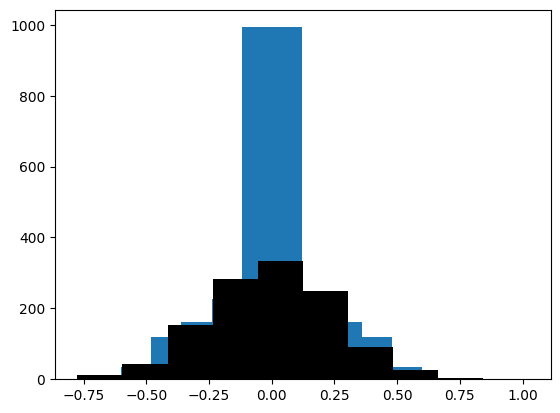

In [56]:
plt.hist(is_true_drift.flatten()*(1./256))
eps = 4*np.sqrt(1./256)*np.random.normal(loc=0., scale=1., size=(100, 1, config.ndims))
plt.hist(eps.flatten(), color="black")

In [58]:
from utils.drift_evaluation_functions import IID_NW_multivar_estimator
num_paths = 1000
grid_1d = np.array([bws[25]])
my_bws = np.stack([grid_1d for m in range(config.ndims)], axis=-1)
assert (my_bws.shape == (1, config.ndims))
bw = my_bws[0,:]
inv_H = np.diag(np.power(bw, -2))
norm_const = 1 / np.sqrt((2. * np.pi) ** config.ndims * (1. / np.linalg.det(inv_H)))
is_path_observations = np.load(config.data_path, allow_pickle=True)[:num_paths, :, :]
is_path_observations = np.concatenate(
            [np.repeat(np.array(config.initState).reshape((1, 1, config.ndims)), is_path_observations.shape[0], axis=0),
             is_path_observations], axis=1)
assert is_path_observations.shape == (num_paths, config.ts_length + 1, config.ndims)
is_idxs = np.arange(is_path_observations.shape[0])
path_observations = is_path_observations[np.random.choice(is_idxs, size=num_paths, replace=False), :]
# We note that we DO NOT evaluate the drift at time t_{0}=0
# We therefore remove the first element of path_observations since it includes X_{t_{0}} = X_{0}
# We also remove the last element since we never evaluate the drift at that point
t0 = config.deltaT
prevPath_observations = path_observations[:, 1:-1, :]
# We compute the path incs with respect to the prevPath_observations (since X_{t_{0}} != X_{0})
print(np.load(true_files[5]).shape)
path_incs = np.diff(path_observations, axis=1)[:, 1:, :]
states_to_eval = np.load(true_files[25])[0,:,:,:][:, 0, :]
drift_estimator_via_track = IID_NW_multivar_estimator(prevPath_observations=prevPath_observations, inv_H=inv_H,
                                               norm_const=norm_const,
                                               x=states_to_eval, path_incs=path_incs, t1=config.t1,
                                               t0=config.t0, truncate=True)[:, np.newaxis, :]

states_to_eval + drift_estimator_via_track*(1/256) + eps


(10, 100, 257, 12)


array([[[ 0.34806928,  0.52183229,  0.60788237, ...,  0.16790854,
          0.05370406,  0.21062867],
        [ 0.34806928,  0.52183229,  0.60788237, ...,  0.16790854,
          0.05370406,  0.21062867],
        [ 0.34806928,  0.52183229,  0.60788237, ...,  0.16790854,
          0.05370406,  0.21062867],
        ...,
        [ 0.34806928,  0.52183229,  0.60788237, ...,  0.16790854,
          0.05370406,  0.21062867],
        [ 0.34806928,  0.52183229,  0.60788237, ...,  0.16790854,
          0.05370406,  0.21062867],
        [ 0.34806928,  0.52183229,  0.60788237, ...,  0.16790854,
          0.05370406,  0.21062867]],

       [[ 0.30051361,  0.06119594,  0.47619277, ...,  0.32569727,
          0.18284748,  0.38197845],
        [ 0.30051361,  0.06119594,  0.47619277, ...,  0.32569727,
          0.18284748,  0.38197845],
        [ 0.30051361,  0.06119594,  0.47619277, ...,  0.32569727,
          0.18284748,  0.38197845],
        ...,
        [ 0.30051361,  0.06119594,  0.47619277, ...,  

In [59]:
is_ss_path_observations = is_path_observations[np.random.choice(is_idxs, size=num_paths, replace=False), :]
is_prevPath_observations = is_ss_path_observations[:, 1:-1]
is_path_incs = np.diff(is_ss_path_observations, axis=1)[:, 1:]
unif_is_drift_hats= IID_NW_multivar_estimator(prevPath_observations=is_prevPath_observations, inv_H=inv_H, x=states_to_eval,
                                                    path_incs=is_path_incs, t1=config.t1, t0=t0, truncate=True, norm_const=norm_const)
states_to_eval + unif_is_drift_hats*(1/256) + eps

array([[[ 0.34692856,  0.52069157,  0.60674165, ...,  0.16676782,
          0.05256334,  0.20948795],
        [ 0.34692856,  0.52069157,  0.60674165, ...,  0.16676782,
          0.05256334,  0.20948795],
        [ 0.34692856,  0.52069157,  0.60674165, ...,  0.16676782,
          0.05256334,  0.20948795],
        ...,
        [ 0.34692856,  0.52069157,  0.60674165, ...,  0.16676782,
          0.05256334,  0.20948795],
        [ 0.34692856,  0.52069157,  0.60674165, ...,  0.16676782,
          0.05256334,  0.20948795],
        [ 0.34692856,  0.52069157,  0.60674165, ...,  0.16676782,
          0.05256334,  0.20948795]],

       [[ 0.2993729 ,  0.06005523,  0.47505206, ...,  0.32455655,
          0.18170677,  0.38083773],
        [ 0.2993729 ,  0.06005523,  0.47505206, ...,  0.32455655,
          0.18170677,  0.38083773],
        [ 0.2993729 ,  0.06005523,  0.47505206, ...,  0.32455655,
          0.18170677,  0.38083773],
        ...,
        [ 0.2993729 ,  0.06005523,  0.47505206, ...,  

In [60]:
def true_drift(prev, num_paths, config):
    assert (prev.shape == (num_paths, config.ndims))
    drift_X = -(4. * np.array(config.quartic_coeff) * np.power(prev,
                                                               3) + 2. * np.array(config.quad_coeff) * prev + np.array(
        config.const))
    return drift_X[:, np.newaxis, :]

true_mean = true_drift(states_to_eval, num_paths=100, config=config)
states_to_eval + true_mean*(1/256) + eps

array([[[ 0.05605166,  0.22981471,  0.31586481, ..., -0.12410934,
         -0.23831392, -0.08138944],
        [ 0.05605166,  0.22981471,  0.31586481, ..., -0.12410934,
         -0.23831392, -0.08138944],
        [ 0.05605166,  0.22981471,  0.31586481, ..., -0.12410934,
         -0.23831392, -0.08138944],
        ...,
        [ 0.05605166,  0.22981471,  0.31586481, ..., -0.12410934,
         -0.23831392, -0.08138944],
        [ 0.05605166,  0.22981471,  0.31586481, ..., -0.12410934,
         -0.23831392, -0.08138944],
        [ 0.05605166,  0.22981471,  0.31586481, ..., -0.12410934,
         -0.23831392, -0.08138944]],

       [[ 0.008496  , -0.23082164,  0.18417521, ...,  0.0336794 ,
         -0.1091705 ,  0.08996034],
        [ 0.008496  , -0.23082164,  0.18417521, ...,  0.0336794 ,
         -0.1091705 ,  0.08996034],
        [ 0.008496  , -0.23082164,  0.18417521, ...,  0.0336794 ,
         -0.1091705 ,  0.08996034],
        ...,
        [ 0.008496  , -0.23082164,  0.18417521, ...,  

In [41]:
np.load(true_files[25])[:, :, :, 0]

array([[[ 0.00000000e+00,  1.04582491e-01,  1.19881753e-01, ...,
          2.23630581e+00,  2.25782585e+00,  2.22635596e+00],
        [ 0.00000000e+00,  2.51489298e-01,  5.62238662e-01, ...,
         -8.96949120e-01, -5.81769890e-01, -7.97682122e-01],
        [ 0.00000000e+00, -3.28949517e-02,  4.95010197e-02, ...,
          2.44365150e+00,  2.42547250e+00,  2.05170195e+00],
        ...,
        [ 0.00000000e+00, -1.42875428e-01,  2.59406767e-01, ...,
          3.22911142e-01,  6.22026568e-01,  8.05974916e-01],
        [ 0.00000000e+00, -2.80875997e-01, -5.00700212e-01, ...,
         -2.73133932e+00, -3.10155510e+00, -3.45807178e+00],
        [ 0.00000000e+00,  4.33869600e-01,  6.62001353e-01, ...,
          2.15535666e+00,  1.98346362e+00,  1.99546475e+00]],

       [[ 0.00000000e+00,  3.13623592e-01,  1.76017970e-01, ...,
         -4.23420069e-01, -2.11455847e-01,  1.67417090e-01],
        [ 0.00000000e+00, -9.07142916e-02,  1.16520809e-01, ...,
         -9.93690937e-02, -9.79369402e

In [43]:
np.load(local_files[25])[:,:,:,0]

array([[[ 0.        ,  0.10444854,  0.11825212, ...,  2.23023006,
          2.26657071,  2.23603795],
        [ 0.        ,  0.25135535,  0.55837127, ..., -0.88555917,
         -0.57057385, -0.78936112],
        [ 0.        , -0.0330289 ,  0.05001486, ...,  2.50229154,
          2.44429083,  2.06954165],
        ...,
        [ 0.        , -0.14300938,  0.2616278 , ...,  0.31335322,
          0.61711261,  0.79719588],
        [ 0.        , -0.28100995, -0.49639808, ..., -2.75524105,
         -3.13847315, -3.52615629],
        [ 0.        ,  0.43373565,  0.65554117, ...,  2.14975337,
          1.98889884,  1.99495438]],

       [[ 0.        ,  0.31348964,  0.1712381 , ..., -0.4134957 ,
         -0.20513644,  0.17068415],
        [ 0.        , -0.09084824,  0.1179353 , ..., -0.09733647,
         -0.00824488,  0.00679733],
        [ 0.        , -0.16855041, -0.07576095, ...,  2.61001876,
          2.36793134,  2.39552137],
        ...,
        [ 0.        ,  0.1306306 ,  0.1852211 , ..., -

In [42]:
(np.load(local_files[25])-np.load(true_files[25]))[:,:,:, 0]

array([[[ 0.        , -0.00013395, -0.00162963, ..., -0.00607575,
          0.00874486,  0.00968199],
        [ 0.        , -0.00013395, -0.00386739, ...,  0.01138995,
          0.01119604,  0.008321  ],
        [ 0.        , -0.00013395,  0.00051384, ...,  0.05864004,
          0.01881834,  0.0178397 ],
        ...,
        [ 0.        , -0.00013395,  0.00222104, ..., -0.00955792,
         -0.00491396, -0.00877904],
        [ 0.        , -0.00013395,  0.00430213, ..., -0.02390173,
         -0.03691805, -0.06808451],
        [ 0.        , -0.00013395, -0.00646018, ..., -0.00560329,
          0.00543522, -0.00051037]],

       [[ 0.        , -0.00013395, -0.00477987, ...,  0.00992437,
          0.0063194 ,  0.00326706],
        [ 0.        , -0.00013395,  0.00141449, ...,  0.00203263,
          0.00154881,  0.00015302],
        [ 0.        , -0.00013395,  0.00261285, ...,  0.02187155,
          0.02728176,  0.01351945],
        ...,
        [ 0.        , -0.00013395, -0.00203446, ..., -